This is the notebook for the signal processing of a magnet signal in the lecture Sensors and Signal Processing.

In [1]:
#!pip install plotly

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.linear_model import LinearRegression

# Estimating the sensitivity and resolution of the magnetometer

In [3]:
def moving_average2(signal, window_size):
    """
    Compute the moving average of a time signal using a given window size.

    Parameters:
    signal (numpy.ndarray): The input time signal.
    window_size (int): The size of the moving window.

    Returns:
    numpy.ndarray: The moving average of the input signal.
    """
    # Define the convolution kernel for computing the moving average
    kernel = np.ones(window_size) / window_size

    # Use numpy.convolve() to compute the moving average
    moving_avg = np.convolve(signal, kernel, mode='same')

    return moving_avg

In [101]:
path = f"./data_raw/Raw Data-earth.csv"
df_one = pd.read_csv(path)
df_one = df_one[300:]
# plt.plot(df_one['Time (s)'], df_one['Absolute field (µT)'])
# plt.show()

mean_abs = np.mean(df_one['Absolute field (µT)'])
df_one['Compensated'] = df_one['Absolute field (µT)']-mean_abs
std = np.std(df_one['Compensated'])
print('Resolution:' , std)
# plt.hist(df_one['Compensated'])
# plt.show()
df_one['moved std'] = df_one['Compensated'] + std



fig = go.Figure()

fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['Compensated'], mode='lines', name='Compensated', line=dict(color='slateblue', width = 4)))
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['moved std'], mode='lines', name='Moved by Std', line=dict(color='darkorange', width = 4)))

fig.update_layout(
    title = dict(text = 'Compensated signal and signal moved by 1 STD',  x = 0.43, xanchor = 'center', font=  dict(size = 50)),
    width = 1600,
    height = 800,
    margin = dict(l=50, r=50, t=100, b=50),
    legend = dict(font = dict(size = 35))
)

fig.update_xaxes(title_text='Time (s)', title_font=dict(size=35), tickfont=dict(size=30))

fig.update_yaxes(title_text='Compensated magnetic field (µT)', title_font=dict(size=35), tickfont=dict(size=30))

fig.show()

ma = moving_average2(df_one['Compensated'].to_numpy(), 30)

Resolution: 0.14836272814730786


In [106]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=df_one['Compensated'], mode='lines', name='Compensated', line=dict(color='slateblue', width = 4)))
fig.add_trace(go.Scatter(x=df_one['Time (s)'], y=ma, mode='lines', name='Moving Average', line=dict(color='darkorange', width = 4)))


fig.update_layout(
    title = dict(text = 'Compensated Signal and Moving Average',  x = 0.43, xanchor = 'center', font= dict(size = 50)),
    width = 1600,
    height = 800,
    margin = dict(l=50, r=50, t=100, b=50),
    legend=dict(font=dict(size=30))
)

fig.update_xaxes(title_text='Time (s)', title_font=dict(size=35), tickfont=dict(size=30))

fig.update_yaxes(title_text='Compensated magnetic field (µT)', title_font=dict(size=35), tickfont=dict(size=30))


fig.show()

In [85]:
# Read in file paths

file_paths = [f"./data_raw/Raw Data-{i}.csv" for i in range(1, 5)]
dfs = []

# Iterate over each file, read it into a dataframe, and add a column for experiment index
for idx, file_path in enumerate(file_paths, start=1):
    df = pd.read_csv(file_path)
    df['Experiment_Index'] = idx
    dfs.append(df)

# Put the dataframes together
combined_df = pd.concat(dfs, ignore_index=True)
threshold_value = 100

# Lists for indices where it rises and falls back down to normal values (no external magnetic field)
sharp_rise_indices = []
descent_indices = []
for experiment_idx, group_df in combined_df.groupby('Experiment_Index'):
    # Find sharp rise index
    sharp_rise_index = group_df['Absolute field (µT)'].diff().gt(threshold_value).idxmax()
    sharp_rise_indices.append(sharp_rise_index)

    # Find descent index
    start_index = group_df.index.get_loc(sharp_rise_index)  # Start searching from sharp rise index
    sharp_rise_value = group_df.loc[sharp_rise_index, 'Absolute field (µT)']
    threshold_descent = sharp_rise_value - threshold_value # Make sure the value is really significantly smaller
    descent_index = group_df.iloc[start_index:]['Absolute field (µT)'].lt(threshold_descent).idxmax()
    descent_indices.append(descent_index)

selected_rows = []
for sharp_rise_index, descent_index in zip(sharp_rise_indices, descent_indices):
    selected_rows.append(combined_df.loc[sharp_rise_index:descent_index])

selected_df = pd.concat(selected_rows)

print("Indices where a sharp rise occurs: ", sharp_rise_indices)
print("Indices where it descends again", descent_indices)

Indices where a sharp rise occurs:  [219, 1938, 3778, 5958]
Indices where it descends again [1147, 3071, 5081, 7118]


[1293.6267516241119, 647.743626367769, -660.6787834920368, -1309.9933991832904]
[1291.145211980288, 649.6608608352168, -649.6608608352168, -1291.145211980288]


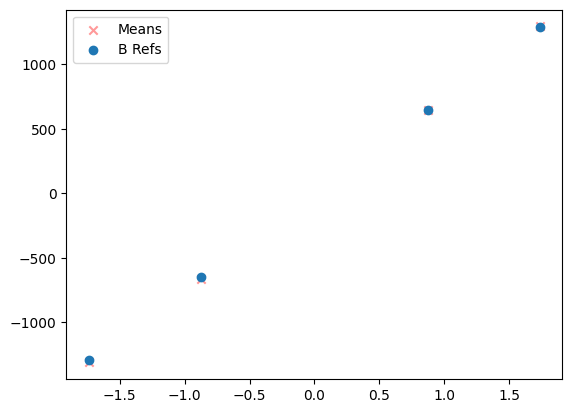

In [86]:
# Get the mean of measurements for each experiment and add it to a list
measured_means = []
for i in range(1,5):
    measured_mean = selected_df[selected_df['Experiment_Index'] == i]['Magnetic Field y (µT)'].mean()
    # measured_mean /= 10^6
    measured_means.append(measured_mean)
measured_means_in_T= [value / 1000000 for value in measured_means]
print(measured_means)

x = [1,2,3,4]
currents = [1.737, 0.874, -0.874, -1.737]

def B_ref(current):
    mu = 4 * np.pi * 10**(-7)
    N = 124
    R = 0.15
    return mu * (8*current*N) / (np.sqrt(125)*R)

brefs = []
for i in range(0,4):
    brefs.append(B_ref(currents[i]) * 10**6)
print(brefs)

plt.scatter(x=currents, y=measured_means, label='Means', marker='x', alpha=.4, color='red')
plt.scatter(x=currents, y=brefs, label='B Refs')
plt.legend()
plt.show()

In [108]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=currents, y=measured_means, mode='markers', marker=dict(color='slateblue', size=30, opacity=0.5), name='Measured Means'))
fig.add_trace(go.Scatter(x=currents, y=brefs, mode='markers', marker=dict(color='darkorange', size=20, opacity=0.8), name='Calculated <i>B<sub>refs</sub></i> '))

# Add title and axis labels
fig.update_layout(
    title=dict(text = "Scatter Plot of Measured <i>B<sub>y</sub></i> and <i>B<sub>ref</sub></i>  vs. Current", x = 0.45, xanchor = 'center', font=dict(size=50)),
    legend = dict(font = dict(size = 35)),
    width = 1500,  
    height = 800,  
    margin = dict(l = 50, r = 50, b = 50, t = 100), 
        shapes=[dict(
        type='rect',
        xref='paper', yref='paper',
        x0=0, y0=0, x1=1, y1=1,
        line=dict(color='black', width=2)
    )]
)

fig.update_xaxes(title_text='Currents [A]', title_font=dict(size=35), tickfont=dict(size=30))

fig.update_yaxes(title_text='Magnetic Field [µT]', title_font=dict(size=35), tickfont=dict(size=30))    
    






# Show the plot
fig.show()

In [23]:
slope, intercept, r_value, _, _ = scipy.stats.linregress(x=currents, y=measured_means_in_T)
print("The Pearson R coefficient for the measured means is: ", r_value)

The Pearson R coefficient for the measured means is:  0.999999528186711


### Plotting measured magnetic field against Bref with linear fit

In [24]:
slope, intercept, r_value, _, _ = scipy.stats.linregress(x=brefs, y=measured_means_in_T)
print("The Pearson R coefficient for the measured means is: ", r_value)

regression_line = [slope * x + intercept for x in brefs]

fig = go.Figure()

fig.add_trace(go.Scatter(x=brefs, y=measured_means_in_T, mode='markers', 
                         marker=dict(size=10, opacity=1), name='Measured B_y vs B_ref'))


fig.add_trace(go.Scatter(x=brefs, y=regression_line, mode='lines', 
                         line=dict(color='blue'),name='Regression Line', opacity=0.3))

fig.update_layout(
    title=dict(text="Scatter Plot of Measured B_y vs B_ref", x=0.36, xanchor='center'),
    xaxis_title="Reference Magnetic Field [T]",
    yaxis_title="Measured Magnetic Field [T]",
    width=700,  # Adjust width as needed
    height=500,  # Adjust height as needed
    margin=dict(l=50, r=50, b=50, t=50),
            shapes=[dict(
        type='rect',
        xref='paper', yref='paper',
        x0=0, y0=0, x1=1, y1=1,
        line=dict(color='black', width=2)
    )]
)


fig.add_annotation(
    x=1.42, y=0.85,  # Position of the annotation (adjust x and y as needed)
    xref='paper', yref='paper',  # Referencing the paper coordinates
    text=f"Pearson R: {r_value:.10f}",  # Annotation text
    showarrow=False,  # Hide the arrow
    font=dict(size=12),  # Adjust font size as needed
)

fig.show()




The Pearson R coefficient for the measured means is:  0.9999995281867112


### Tracking Data Extraction

In [77]:
path_to_tracking = "./data_raw/Raw Data-tracking.csv"
df_tracking = pd.read_csv(path_to_tracking)
# threshold_value = 50

# Initialize the experiment index and the flag, for analysis

threshold = 95
df_tracking['Experiment_Index'] = 0
current_index = 0
below_threshold = False  # Flag to track whether we're currently below the threshold

for i in range(len(df_tracking)):
    value = df_tracking.loc[i, 'Absolute field (µT)']

    if value < threshold and not below_threshold:
        # If the value is below the threshold and we are not already in a "below threshold" state
        current_index += 1  # Increment the experiment index
        below_threshold = True  # Set the flag to True since we're now below the threshold
    elif value >= threshold:
        # If the value is above the threshold, reset the below threshold flag
        below_threshold = False

    # Assign the current experiment index
    df_tracking.loc[i, 'Experiment_Index'] = current_index
display(df_tracking)

color_map = {
    1: 'red',
    2: 'blue',
    3: 'green',
    4: 'purple',
    5: 'orange',
    6: 'brown',
    7: 'pink'
}
# Create a figure
fig = go.Figure()

# Add the line plot
fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Absolute field (µT)'],
                         mode='lines', name='Absolute Field'))

# Define colors for each experiment index
colors = {
    1: 'rgba(255, 0, 0, 0.7)',  # red
    2: 'rgba(0, 0, 255, 0.7)',  # blue
    3: 'rgba(0, 255, 0, 0.7)',  # green
    4: 'rgba(128, 0, 128, 0.7)',  # purple
    5: 'rgba(255, 165, 0, 0.7)',  # orange
    6: 'rgba(165, 42, 42, 0.7)',  # brown
    7: 'rgba(255, 192, 203, 0.9)'  # pink
}

# Add shaded regions for each experiment index
for experiment_index in df_tracking['Experiment_Index'].unique():
    df_subset = df_tracking[df_tracking['Experiment_Index'] == experiment_index]
    start_time = df_subset['Time (s)'].min()
    end_time = df_subset['Time (s)'].max()

    fig.add_shape(type='rect',
                  x0=start_time, x1=end_time,
                  y0=df_tracking['Absolute field (µT)'].min(), y1=df_tracking['Absolute field (µT)'].max(),
                  fillcolor=colors[experiment_index], opacity=0.2, line_width=0)

# Update layout
fig.update_layout(title='Absolute Field vs. Time with Shaded Experiment Regions',
                  xaxis_title='Time (s)',
                  yaxis_title='Absolute field (µT)')

# Show the plot
fig.show()
# fig = px.line(df_tracking, x='Time (s)', y='Absolute field (µT)', title="Absolute Field vs. Time",
#               line_shape='linear', render_mode='svg', color='Experiment_Index',
#               color_discrete_map=color_map)

# fig.show()

,Time (s),Magnetic Field x (µT),Magnetic Field y (µT),Magnetic Field z (µT),Absolute field (µT),Experiment_Index
0,0.010507,37.711456,-53.869354,-63.459534,91.384756,1
1,0.020470,37.735016,-53.843094,-63.455551,91.376240,1
2,0.030433,37.790863,-53.916626,-63.410339,91.411285,1
3,0.040396,37.761078,-53.911957,-63.562973,91.502184,1
4,0.050359,37.761627,-53.979919,-63.476212,91.482248,1
...,...,...,...,...,...,...
2217,22.098263,-250.929916,-687.699890,-35.507980,732.910485,7
2218,22.108226,-250.962311,-688.302612,-35.441696,733.483934,7
2219,22.118189,-251.056427,-688.026794,-35.326950,733.251794,7
2220,22.128152,-250.930939,-687.661743,-35.059250,732.853437,7


### Making all the plots together (Absolute, x, y and z)

In [117]:
from plotly.subplots import make_subplots


# Create a figure
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.05)


fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Absolute field (µT)'],
                         mode='lines', name='Absolute Field'))


fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Magnetic Field x (µT)'],
                         mode='lines', name='Magnetic Field x (µT)'), row=2, col=1)

fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Magnetic Field y (µT)'],
                         mode='lines', name='Magnetic Field y (µT)'), row=3, col=1)


fig.add_trace(go.Scatter(x=df_tracking['Time (s)'], y=df_tracking['Magnetic Field z (µT)'],
                         mode='lines', name='Magnetic Field z (µT)'), row=4, col=1)

# Define colors for each experiment index
colors = {
    1: 'rgba(255, 0, 0, 0.7)',  # red
    2: 'rgba(0, 0, 255, 0.7)',  # blue
    3: 'rgba(0, 255, 0, 0.7)',  # green
    4: 'rgba(128, 0, 128, 0.7)',  # purple
    5: 'rgba(255, 165, 0, 0.7)',  # orange
    6: 'rgba(165, 42, 42, 0.7)',  # brown
    7: 'rgba(255, 192, 203, 0.9)'  # pink
}


shapes = []
for experiment_index in df_tracking['Experiment_Index'].unique():
    df_subset = df_tracking[df_tracking['Experiment_Index'] == experiment_index]
    start_time = df_subset['Time (s)'].min()
    end_time = df_subset['Time (s)'].max()
    
   
    shapes.append(dict(type='rect',
                       xref='x', yref='y1',
                       x0=start_time, x1=end_time,
                       y0=df_tracking['Absolute field (µT)'].min(), y1=df_tracking['Absolute field (µT)'].max(),
                       fillcolor=colors[experiment_index], opacity=0.2, line_width=0))
    
  
    shapes.append(dict(type='rect',
                       xref='x', yref='y2',
                       x0=start_time, x1=end_time,
                       y0=df_tracking['Magnetic Field x (µT)'].min(), y1=df_tracking['Magnetic Field x (µT)'].max(),
                       fillcolor=colors[experiment_index], opacity=0.2, line_width=0))

    shapes.append(dict(type='rect',
                       xref='x', yref='y3',
                       x0=start_time, x1=end_time,
                       y0=df_tracking['Magnetic Field y (µT)'].min(), y1=df_tracking['Magnetic Field y (µT)'].max(),
                       fillcolor=colors[experiment_index], opacity=0.2, line_width=0))    

    shapes.append(dict(type='rect',
                       xref='x', yref='y4',
                       x0=start_time, x1=end_time,
                       y0=df_tracking['Magnetic Field z (µT)'].min(), y1=df_tracking['Magnetic Field z (µT)'].max(),
                       fillcolor=colors[experiment_index], opacity=0.2, line_width=0))   



# title
fig.update_layout(title = dict(text = 'Magnetic Field vs. Time with shaded experiment regions', x=0.5, xanchor = 'center', font=dict(size=40)),
                  width=1500,  # Adjust width as needed
                  height=800,  # Adjust height as needed
                  margin=dict(l=50, r=50, b=50, t=100),
                  shapes=shapes,
                  #showlegend = False
                  legend = dict(font = dict(size = 25))
                  )


# x-axis title
fig.update_xaxes(title_text='Time (s)', row=4, col=1, title_font=dict(size=30), tickfont=dict(size=20))  

# y-axis title
fig.update_yaxes(title_text='Magnetic field (µT)', row=2, col=1, title_standoff = 10, title_font=dict(size=30), tickfont=dict(size=20))
fig.update_yaxes(row=1, col=1, title_font=dict(size=30), tickfont=dict(size=20)) 
fig.update_yaxes(row=3, col=1, title_font=dict(size=30), tickfont=dict(size=20))
fig.update_yaxes(row=4, col=1, title_font=dict(size=30), tickfont=dict(size=20))

fig.show()


### Indexing and calculating the means of the plateaus

In [27]:
# Identify plateaus using rolling windows
def find_plateau_regions(df, threshold):
    """
    Find plateau regions in the signal data.

    Args:
    df (pd.DataFrame): DataFrame containing signal data.
    threshold (float): Threshold for detecting plateaus.

    Returns:
    dict: Dictionary containing plateau regions for each column.
    """
    plateau_regions_dict = {}

    for col in df.columns:
        # Smooth the signal data using rolling window averaging
        window_size = 2
        smoothed_signal = df[col].rolling(window=window_size, min_periods=1).mean()

        # Calculate the difference between consecutive smoothed values
        diff_smoothed_signal = smoothed_signal.diff()

        # Find indices where the difference is below the threshold
        plateau_indices = diff_smoothed_signal.abs() < threshold

        plateau_regions = []
        start_index = None
        for index, value in plateau_indices.items():
            if value:  # If the difference is below the threshold
                if start_index is None:
                    start_index = index  # Start of plateau region
            elif start_index is not None:
                end_index = index - 1  # End of plateau region
                plateau_regions.append((start_index, end_index))
                start_index = None

        plateau_regions_dict[col] = plateau_regions

    return plateau_regions_dict

threshold_value = .5
df_trunc = df_tracking.copy()
plateau_regions = find_plateau_regions(df_trunc, threshold_value)
plateau_regions = dict(list(plateau_regions.items())[1:-1])
# print(plateau_regions)

In [28]:
# analyze plateaus and indices for all axes
# Print the values of the second key in plateau_regions_dict
second_key_x = list(plateau_regions.keys())[0]  # 0 = x, 1 = y, 2 = z
plateau_regions_values = plateau_regions[second_key_x]

print(f"Plateau regions for {second_key_x}:")
start_list = []
end_list = []
for start_index, end_index in plateau_regions_values:
    start_list.append(start_index)
    end_list.append(end_index)
    print(f"Start index: {start_index}, End index: {end_index}")

# Create a line plot of Magnetic Field x vs. Time
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_trunc['Time (s)'], y=df_trunc['Magnetic Field z (µT)'],
                         mode='lines', name='Magnetic Field z', line=dict(color='black')))

# Iterate through each pair of start and end indices
for i, (start_index, end_index) in enumerate(zip(start_list, end_list)):
    # Extract x and y values for the pair
    x_values = [df_trunc.loc[start_index, 'Time (s)'], df_trunc.loc[end_index, 'Time (s)']]
    y_values = [df_trunc.loc[start_index, 'Magnetic Field z (µT)'], df_trunc.loc[end_index, 'Magnetic Field z (µT)']]

    # Assign a different color to each pair
    color = f"hsl({i * 360 / len(start_list)}, 50%, 50%)"  # Adjust saturation and lightness as needed

    # Add a scatter trace for the pair with the assigned color
    fig.add_trace(go.Scatter(x=x_values, y=y_values, mode='markers', marker=dict(color=color, size=9),
                             name=f'Plateau {i+1}'))

# Update layout
fig.update_layout(title='Magnetic Field z vs. Time with Plateau Regions',
                  xaxis_title='Time (s)',
                  yaxis_title='Magnetic Field z (µT)')

# Show the plot
fig.show()


Plateau regions for Magnetic Field x (µT):
Start index: 1, End index: 52
Start index: 58, End index: 104
Start index: 111, End index: 156
Start index: 163, End index: 206
Start index: 213, End index: 283
Start index: 290, End index: 385
Start index: 390, End index: 435
Start index: 442, End index: 487
Start index: 494, End index: 539
Start index: 546, End index: 614
Start index: 621, End index: 718
Start index: 724, End index: 770
Start index: 777, End index: 820
Start index: 827, End index: 871
Start index: 878, End index: 948
Start index: 955, End index: 1051
Start index: 1057, End index: 1100
Start index: 1107, End index: 1152
Start index: 1159, End index: 1203
Start index: 1210, End index: 1280
Start index: 1287, End index: 1383
Start index: 1389, End index: 1434
Start index: 1441, End index: 1486
Start index: 1493, End index: 1537
Start index: 1544, End index: 1612
Start index: 1619, End index: 1715
Start index: 1721, End index: 1766
Start index: 1773, End index: 1816
Start index:

In [29]:
def extract_median(start_list, end_list, ax):
     """Extracts mean for each plateau

     Args:
         start_list (list): _description_
         end_list (list): _description_
         ax (str): x, y, z or nc - defines the axis that the median will find

     Returns:
         _type_: list of medians, index corresponds to A, B, C, D peaks.
     """
     medians = []
     col = ''
     if ax == 'x':
          col = 'Magnetic Field x (µT)'
     elif ax == 'y':
          col = 'Magnetic Field y (µT)'
     elif ax == 'z':
          col = 'Magnetic Field z (µT)'
     else:
          col = 'Absolute field (µT)'
          
          
     for  start_index, end_index in zip(start_list, end_list):
          medians.append(np.median(df_trunc.loc[start_index:end_index, col]))
     return medians



def consolidate_means(medians, num_repeats = 5):
    """Consolidates medians into groups corresponding to repeating coils.

    Args:
        medians (list): List of median values for each plateau region.
        num_repeats (int): Number of repeats in the experiment.

    Returns:
        list: List of consolidated mean values for each coil (A, B, C, D).
    """
    num_coils = num_repeats  # Number of coils A, B, C, D, etc.
    consolidated_means = []

    for i in range(num_coils):
        group = medians[i::num_coils]
        consolidated_mean = np.mean(group)
        consolidated_means.append(consolidated_mean)
    
    return consolidated_means



meds_x = extract_median(start_list=start_list, end_list=end_list, ax='x')
meds_y = extract_median(start_list=start_list, end_list=end_list, ax='y')
meds_z = extract_median(start_list=start_list, end_list=end_list, ax='z')
meds_nc = extract_median(start_list=start_list, end_list=end_list, ax='nc')



# Consolidate means
consolidated_means_x = consolidate_means(meds_x)
consolidated_means_y = consolidate_means(meds_y)
consolidated_means_z = consolidate_means(meds_z)
consolidated_means_nc = consolidate_means(meds_nc)



# Convert to milliteslas
consolidated_means_x_mT = [val / 1000 for val in consolidated_means_x]
consolidated_means_y_mT = [val / 1000 for val in consolidated_means_y]
consolidated_means_z_mT = [val / 1000 for val in consolidated_means_z]
consolidated_means_nc_mT = [val / 1000 for val in consolidated_means_nc]


table = {
    '': ['No Coil', 'Coil A', 'Coil B', 'Coil C', 'Coil D'],
    'Means for x (mT)': consolidated_means_x_mT,
    'Means for y (mT)': consolidated_means_y_mT,
    'Means for z (mT)': consolidated_means_z_mT,
    'Means for abs (µT)': consolidated_means_nc_mT
}

df_table = pd.DataFrame(table)
print(df_table)

df_table.to_csv('consolidated_means_table.csv', index=False)


            Means for x (mT)  Means for y (mT)  Means for z (mT)  \
0  No Coil          0.037689         -0.053875         -0.063438   
1   Coil A          0.101675         -0.017696         -0.137682   
2   Coil B         -0.172533          0.496115         -0.137610   
3   Coil C          0.108712         -0.098951         -0.139145   
4   Coil D         -0.251158         -0.687878         -0.034943   

   Means for abs (µT)  
0            0.091369  
1            0.172074  
2            0.542983  
3            0.202423  
4            0.733122  


In [30]:
# Matlab values from only one measurement cycle
""" 
Bx_no_coil=0.0378;
By_no_coil=-0.0541;
Bz_no_coil=-63.516;

BxA_raw=0.102;
ByA_raw=-0.0178;
BzA_raw=-137.679;

BxB_raw=-0.172;
ByB_raw=0.496;
BzB_raw=-137.586;

BxC_raw=0.109;
ByC_raw=-0.099;
BzC_raw=-139.216;

BxD_raw=-0.251;
ByD_raw=-0.688;
BzD_raw=-34.916; 

"""

' \nBx_no_coil=0.0378;\nBy_no_coil=-0.0541;\nBz_no_coil=-63.516;\n\nBxA_raw=0.102;\nByA_raw=-0.0178;\nBzA_raw=-137.679;\n\nBxB_raw=-0.172;\nByB_raw=0.496;\nBzB_raw=-137.586;\n\nBxC_raw=0.109;\nByC_raw=-0.099;\nBzC_raw=-139.216;\n\nBxD_raw=-0.251;\nByD_raw=-0.688;\nBzD_raw=-34.916; \n\n'